In [1]:
import cv2
import json
import os
import random
import subprocess
import supervision as sv
import xml.etree.ElementTree as ET
import zipfile

# Download

In [2]:
download_url = 'https://studentiunict-my.sharepoint.com/personal/simone_palazzo_unict_it/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fsimone_palazzo_unict_it%2FDocuments%2FDatasets_released%2Ff4k_detection_tracking%2Ezip'

# Sharepoint doesn't allow automated downloads, so we need to manually download the zip file. 
# Simply copy this link into a browser, and the download will start automatically after authentication.

# Feel free to adjust the paths below to match your local setup.
extract_dir = label_dir = 'f4k_detection_tracking'
zip_file = 'f4k_detection_tracking.zip' 

output_dir = "Images"
mp4_dir = "mp4"

os.makedirs(extract_dir, exist_ok=True)
os.makedirs(mp4_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Optional.
# os.remove(zip_file)  

For ease of processing, we convert `.flv` into `.mp4`.

In [3]:
for filename in os.listdir(extract_dir):
    if filename.endswith(".flv"):
        input_path = os.path.join(extract_dir, filename)
        output_path = os.path.join(mp4_dir, filename.replace(".flv", ".mp4"))

        cmd = [
            "ffmpeg",
            "-i", input_path,
            "-c:v", "libx264",
            "-preset", "veryfast",
            "-crf", "18",
            output_path
        ]

        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Clean Annotations

In [4]:
def find_all_videos(path):
    videos = []
    for filename in os.listdir(path):
        if filename.endswith(".mp4"):
            videos.append(filename.removesuffix(".mp4"))
            
    return videos

def get_all_categories():
    return {category : id for id, category in enumerate(('fish', 'open_sea', 'sea', 'rocks', 
                                                         'coral', 'plant', 'dark_area', 'other', 
                                                         'algae')) }
            
def extract_keyframes(label_path, video_path, video_name, category_id_map, annotation_id):
    tree = ET.parse(label_path)
    root = tree.getroot()

    coco = {
        "images": [],
        "annotations": [],
        "categories": [],
    }

    cap = cv2.VideoCapture(video_path)
    vid_width, vid_height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    correction = 3 if video_name.endswith("122") else 0
    
    for frame in root.findall("frame"):
        frame_id = int(frame.attrib["id"]) + correction
        image_id = f"video_{video_name}_frame_{frame_id}" 
        file_name = image_id + '.jpg'
        save_path = os.path.join(output_dir, file_name)
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame_image = cap.read()
        
        if not ret:
            raise ValueError(f"Failed to read frame {frame_id} from {video_path}")
        
        cv2.imwrite(save_path, frame_image)
        
        coco["images"].append({
            "id": image_id,
            "file_name": file_name, 
            "width": vid_width,  
            "height": vid_height,  
        })

        for obj in frame.findall("object"):
            category_name = obj.attrib["objectType"]
            if category_name in category_id_map:
                category_id = category_id_map[category_name]
                category_id_map[category_name] = category_id
                coco["categories"].append({
                    "id": category_id,
                    "name": category_name,
                })
            else:
                category_id = category_id_map[category_name]

            contour = obj.find("contour").text.strip().split(',')
            
            segmentation = []
            
            for point in contour:
                x, y = map(float, point.split())
                segmentation.extend([x, y])

            xs = segmentation[::2]
            ys = segmentation[1::2]
            xmin = min(xs)
            ymin = min(ys)
            width = max(xs) - xmin
            height = max(ys) - ymin

            coco["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": [segmentation],
                "bbox": [xmin, ymin, width, height],
                "area": width * height,
                "iscrowd": 0,
            })
            
            annotation_id += 1

    return coco, annotation_id


In [5]:
video_names = find_all_videos(mp4_dir)
coco_labels = {'images' : [],
               'annotations' : []}

category_id_map = get_all_categories()
annotation_id = 0

for video_name in video_names:
    label_path = os.path.join(label_dir, video_name + '.xml')
    video_path = os.path.join(mp4_dir, video_name + '.mp4')
    
    coco_dict, annotation_id = extract_keyframes(label_path, video_path, video_name, category_id_map, annotation_id)
    coco_labels['images'].extend(coco_dict['images'])
    coco_labels['annotations'].extend(coco_dict['annotations'])

coco_labels['categories'] = [{'id': id, 'name': name} for name, id in category_id_map.items()]

with open(os.path.join(output_dir, 'annotations_coco.json'), 'w') as f:
    json.dump(coco_labels, f, indent=2) 


In [6]:
dataset = sv.DetectionDataset.from_coco(
        images_directory_path = output_dir,
        annotations_path = os.path.join(output_dir, 'annotations_coco.json')
    )

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")

Dataset length: 913
Dataset classes: ['fish', 'open_sea', 'sea', 'rocks', 'coral', 'plant', 'dark_area', 'other', 'algae']


# Visualise

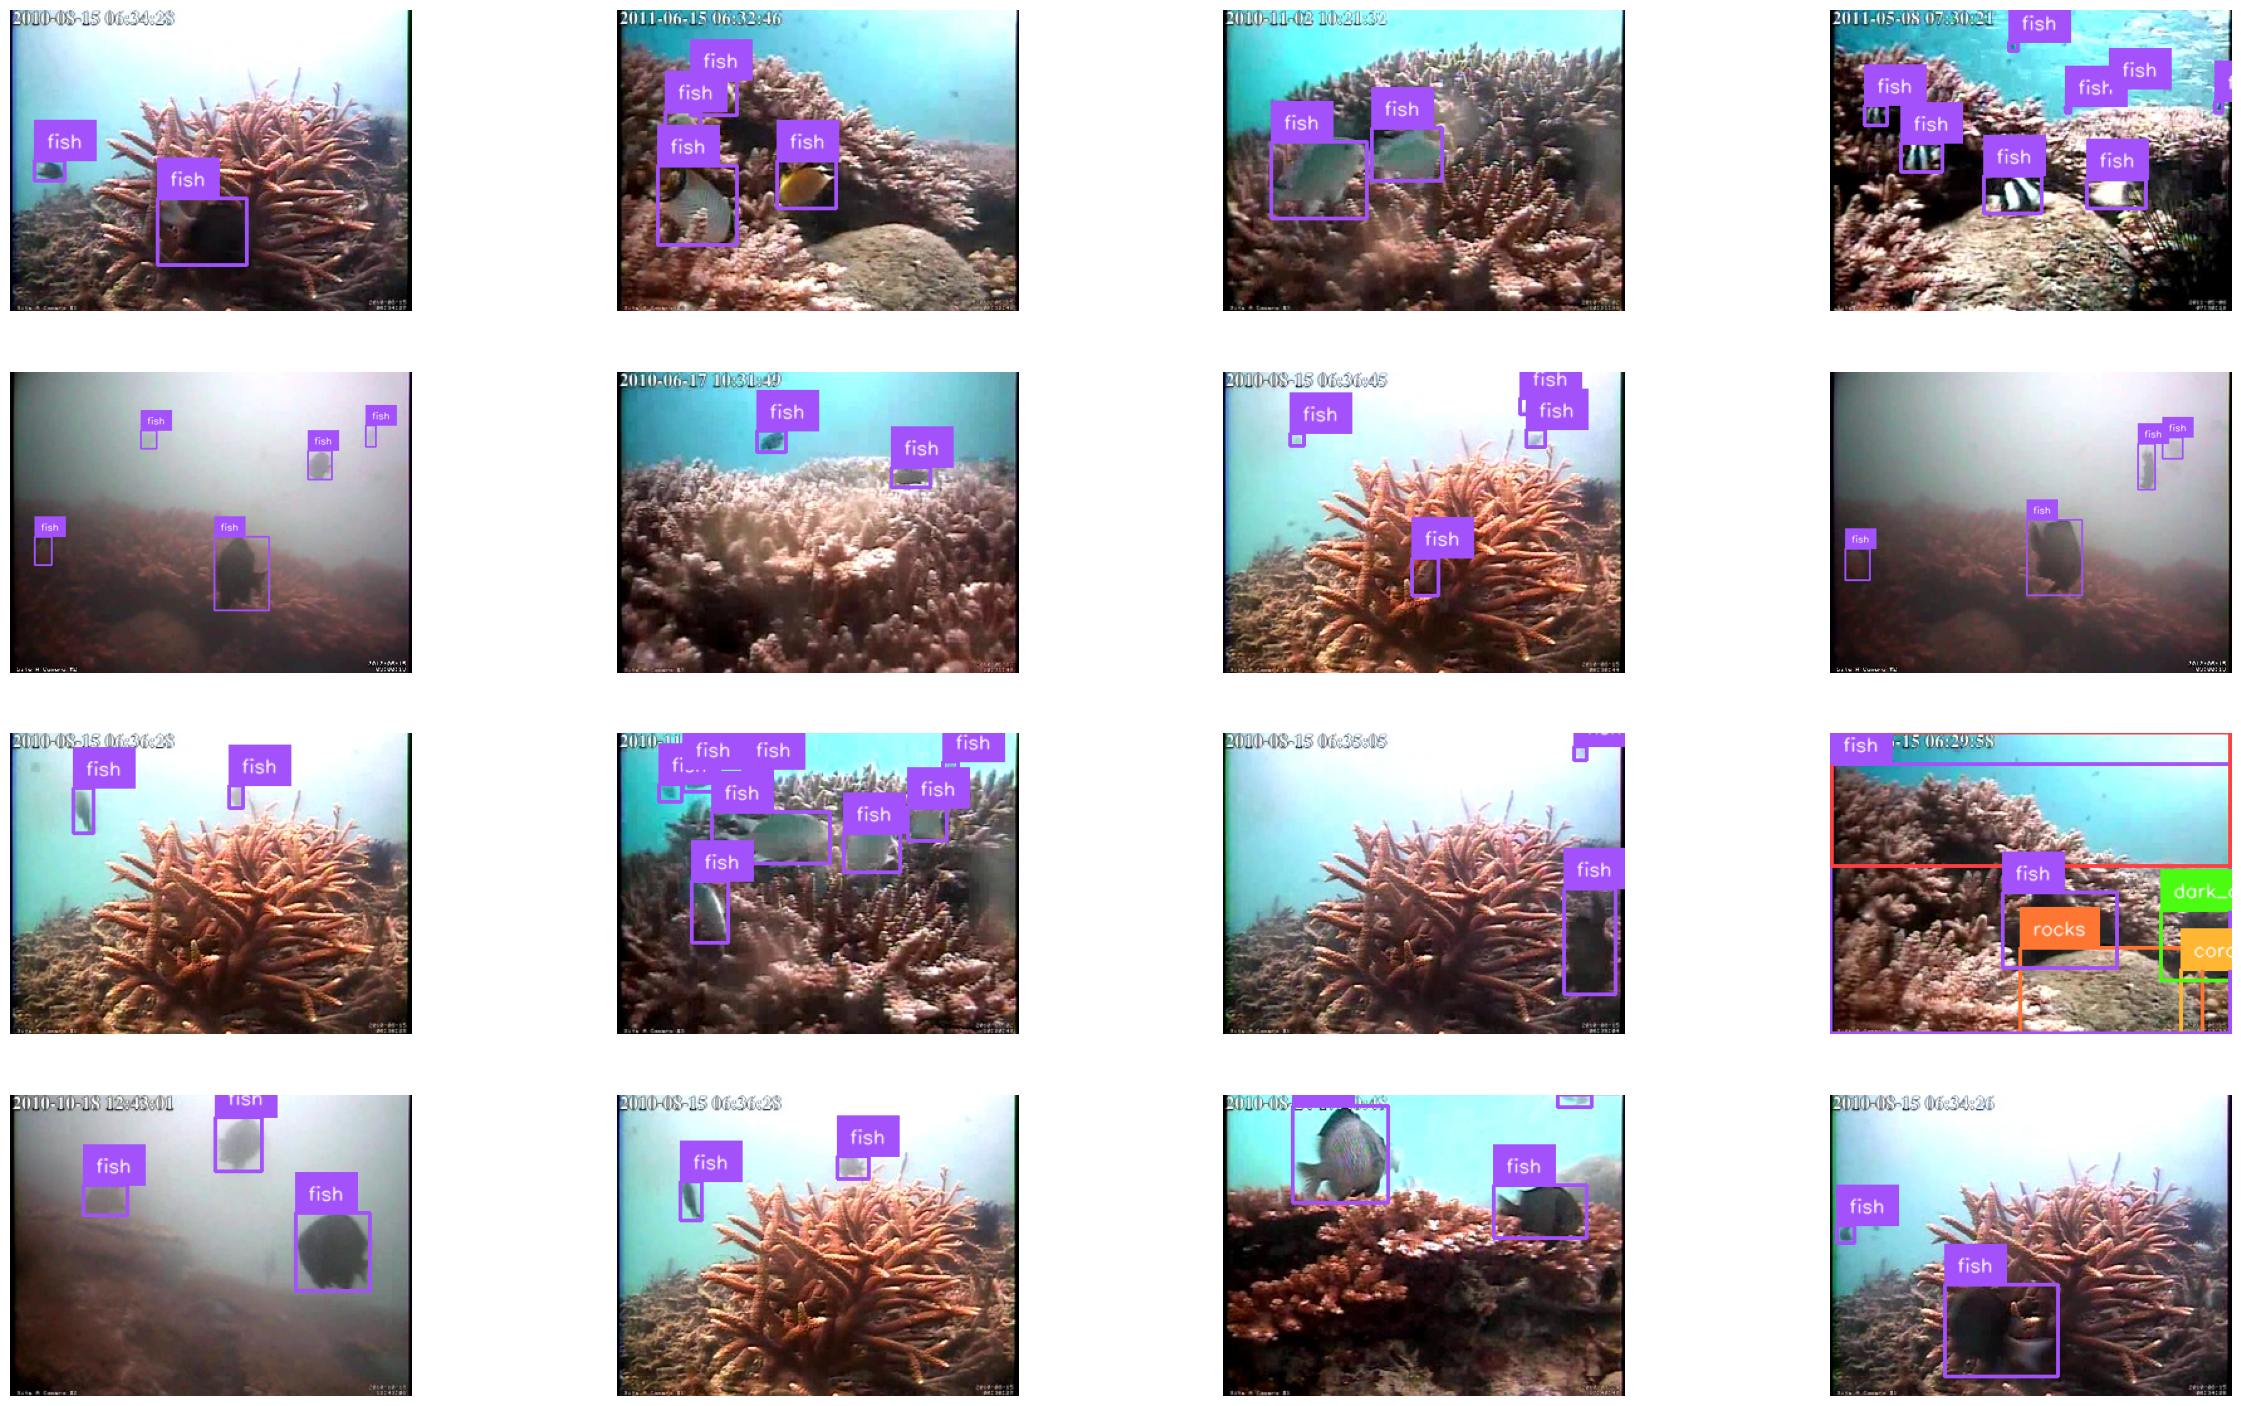

In [7]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

image_example = None

annotated_images = []
for _ in range(16):
    i = random.randint(0, len(dataset))

    _, image, annotations = dataset[i]
    labels = [dataset.classes[class_id] for class_id in annotations.class_id]
     
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels)
    annotated_images.append(annotated_image)
    
    if len(annotations) > 0:
        image_example = annotated_image
    
sv.plot_images_grid(
    annotated_images,
    grid_size=(4, 4),
    titles=None,
    size=(30, 18),
    cmap="gray"
)